In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext dotenv
%dotenv

In [73]:
import pandas as pd
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import datetime as dt
from galaxies import read_nxs_file, detect_scan_from_filename
import os
import glob

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("TimeScans")
logger.setLevel(logging.INFO)

In [3]:
pixel_calibration = np.array([2.02640772e-01, 2.44374424e+03])
roi_left = [70, 100]
roi_right = [285, 315]

In [4]:
def foo():

    files = sorted(glob.glob(os.path.join(os.environ['DATA_PATH'], 'Electrode*.nxs')))

    data = []
    for filename in files:
        scan_type, scan_command, all_data = detect_scan_from_filename(filename, include_full_data=True)
        time_start = all_data.get('start_time', None)
        number_of_energies = len(all_data.get('energies', []))
        exposure_time = all_data.get('exposure_time', [0])[0]/1000  # Convert from ms to seconds

        data.append((time_start, os.path.basename(filename), scan_type, number_of_energies, exposure_time, scan_command))
    df = pd.DataFrame(data, columns=['start_time', 'filename', 'scan_type', 'ene_steps', 'seconds_per_step', 'scan_command'])
    return df

foo()

,start_time,filename,scan_type,ene_steps,seconds_per_step,scan_command
0,2025-05-28T17:23:31,Electrode_01_0001.nxs,plot_2Dmap,1,0.0,
1,2025-05-28T17:35:09,Electrode_01_0002.nxs,plot_2Dmap,5,0.0,
2,2025-05-28T17:53:19,Electrode_01_0003.nxs,plot_2Dmap,0,1.0,
3,2025-05-28T17:55:44,Electrode_01_0004.nxs,plot_2Dmap,5,1.0,
4,2025-05-28T18:01:18,Electrode_01_0005.nxs,plot_2Dmap,31,10.0,
...,...,...,...,...,...,...
166,2025-05-30T13:25:38,Electrode_18_0049.nxs,plot_2Dmap,0,2.0,
167,2025-05-30T13:30:58,Electrode_18_0050.nxs,plot_2Dmap,0,2.0,
168,2025-05-30T13:35:42,Electrode_18_0051.nxs,plot_2Dmap,0,2.0,
169,2025-05-30T13:41:16,Electrode_18_0052.nxs,plot_2Dmap,0,2.0,


In [196]:
def extract_from_time_frames(*, filename, pix2e_calibration, roi, roi_time1, roi_time2=None,
                             vmax_image=None, vmax_time=None, plot=False):
    # logger.setLevel(logging.DEBUG)

    logger.debug("Reading %s", filename)
    data = read_nxs_file(filename, )
    images = data['images']
    logger.debug("Read %i images", len(images))
    logger.debug("Image tensor dimensions: {}".format(images.shape))
    times = np.arange(0, images.shape[0], 1)
    logger.debug("Times array shape: {}".format(times.shape))

    start_time_str = data.get('start_time', None)
    logger.debug("Data start time: %s", start_time_str)
    end_time_str = data.get('end_time', None)
    logger.debug("Data end time: %s", end_time_str)

    # Parse ISO timestrings into unix timestamps
    start_time_dt = dt.datetime.fromisoformat(start_time_str) if start_time_str else None
    end_time_dt = dt.datetime.fromisoformat(end_time_str) if end_time_str else None

    # map the times between start and stop times
    clock_times = np.linspace(start_time_dt+dt.timedelta(seconds=3), end_time_dt-dt.timedelta(seconds=3), len(images))
    logger.debug("New times array shape: {}".format(clock_times.shape))

    # roi = (310, 350)
    E2 = np.polyval(pix2e_calibration, np.arange(0, 195))
    logger.debug("E2 array shape: {}".format(E2.shape))

    fig, axs = None, None
    if plot:
        fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=True, figsize=(12, 8))

        ax = axs[0, 0]
        ax.set_title('Image Sum  ' + filename)
        im = ax.pcolormesh(np.sum(images, axis=0), shading='auto', vmin=0, vmax=vmax_image)
        ax.axvline(roi[0])
        ax.axvline(roi[1])
        fig.colorbar(im, ax=ax)

        ax = axs[0, 1]
        ax.set_title('XES - ' + filename)
        ax.plot(E2, np.sum(images[:, :, roi[0]:roi[1]], axis=(0, 2)))
        ax.set_xlabel('Emitted Energy (eV)')
        ax.set_ylabel('Counts')

    time_2D_map = np.sum(images[:, :, roi[0]:roi[1]], axis=2)
    logger.debug("Time 2D map shape: {}".format(time_2D_map.shape))

    # emitted energy range:
    # roi_time = (80, 130)
    rois_areas_over_time1 = np.sum(images[:, roi_time1[0]:roi_time1[1], roi[0]:roi[1]], axis=(1, 2))
    logger.debug("rois_areas_over_time1 shape: {}".format(rois_areas_over_time1.shape))
    rois_areas_over_time2 = None
    if roi_time2 is not None:
        rois_areas_over_time2 = np.sum(images[:, roi_time2[0]:roi_time2[1], roi[0]:roi[1]], axis=(1, 2))
        logger.debug("rois_areas_over_time2 shape: {}".format(rois_areas_over_time2.shape))

    if roi_time2 is not None:
        result = rois_areas_over_time1 / rois_areas_over_time2
    else:
        result = rois_areas_over_time1

    if plot:
        ax = axs[1, 0]
        ax.set_title('Time dependency - ' + filename)
        im = ax.pcolormesh(E2, times, time_2D_map, shading='auto', vmax=vmax_time)
        ax.set_xlabel('Emitted Energy (eV)')
        ax.set_ylabel('Time [s]')
        ax.axvline(np.polyval(pix2e_calibration, roi_time1[0]))
        ax.axvline(np.polyval(pix2e_calibration, roi_time1[1]))
        if roi_time2 is not None:
            ax.axvline(np.polyval(pix2e_calibration, roi_time2[0]))
            ax.axvline(np.polyval(pix2e_calibration, roi_time2[1]))
        fig.colorbar(im, ax=ax)
        ax.set_xlim(min(E2), max(E2))

        ax = axs[1, 1]
        ax.set_title('Normalized Time dependency of ROIs - ' + filename)
        ax.plot(clock_times, result)
        ax.set_xlabel('CEST Time [s]')

        fig.tight_layout()
        plt.plot()
    logger.setLevel(logging.INFO)

    return pd.Series(result, index=clock_times, name="ROI Area")


# Strong beam

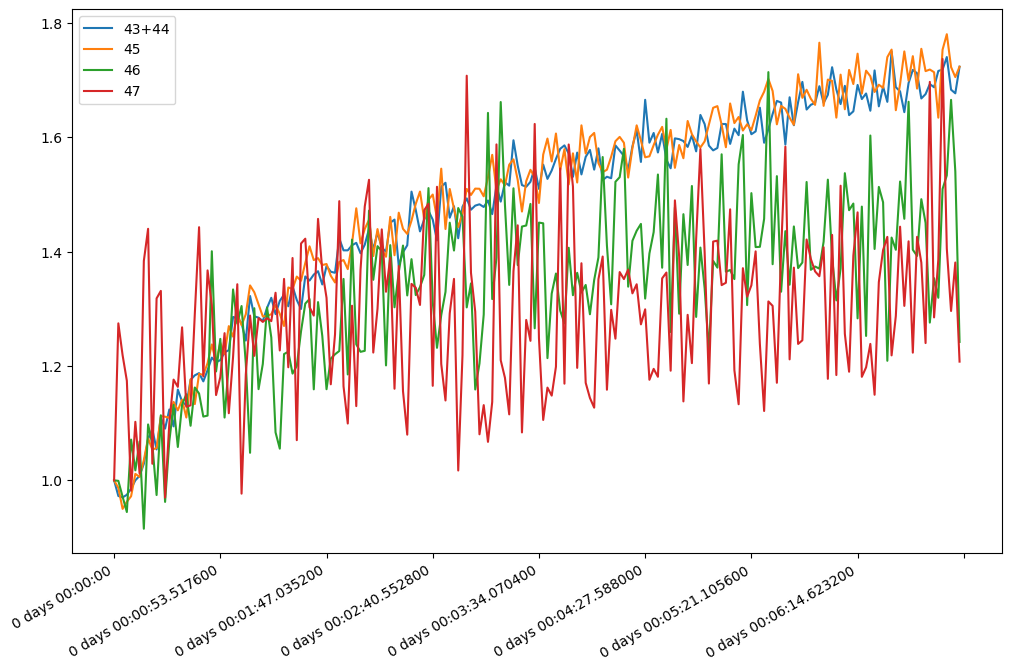

In [217]:

def foo():
    roi_time1 = (80, 135) # whole width
    # roi_time1 = (80, 115) # appearing feature

    # roi_time2 = (80, 135)  # whole width
    roi_time2 = (170, 190)  # elastic

    data_18_43 = dict(filename="Electrode_18_0043.nxs",
                    pix2e_calibration=pixel_calibration,
                    roi=(310, 350),
                    roi_time1=roi_time1,
                    roi_time2=roi_time2,
                    vmax_image=1300,
                    vmax_time=300
                      )

    data_18_44 = dict(filename="Electrode_18_0044.nxs",
                    pix2e_calibration=pixel_calibration,
                    roi=(310, 350),
                    roi_time1=roi_time1,
                    roi_time2=roi_time2,
                    vmax_image=1300,
                    vmax_time=300
                      )

    data_18_45 = dict(filename="Electrode_18_0045.nxs",
                    pix2e_calibration=pixel_calibration,
                    roi=(305, 345),
                    roi_time1=roi_time1,
                    roi_time2=roi_time2,
                    vmax_image=1300,
                    vmax_time=300
                      )

    data_18_46 = dict(filename="Electrode_18_0046.nxs",
                    pix2e_calibration=pixel_calibration,
                    roi=(300, 340),
                    roi_time1=roi_time1,
                    roi_time2=roi_time2,
                    vmax_image=3300,
                    vmax_time=600
                      )

    data_18_47 = dict(filename="Electrode_18_0047.nxs",
                    pix2e_calibration=pixel_calibration,
                    roi=(305, 345),
                    roi_time1=roi_time1,
                    roi_time2=roi_time2,
                    vmax_image=3300,
                    vmax_time=600
                      )



    df_1 = extract_from_time_frames(**data_18_43, plot=False)
    df_2 = extract_from_time_frames(**data_18_44, plot=False)
    df1 = pd.concat([df_1, df_2], axis=0)
    df2 = extract_from_time_frames(**data_18_45, plot=False)
    df3 = extract_from_time_frames(**data_18_46, plot=False)
    df4 = extract_from_time_frames(**data_18_47, plot=False)

    fig = plt.figure(figsize=(12, 8))
    for df in (df1, df2, df3, df4):
        df.index = df.index - df.index[0]
        df = df / df.iloc[0]
        # df.rolling(1).sum().plot()
        df.plot()
    plt.legend(["43+44", "45", "46", "47"])
    # plt.ylim(0.99, 1.6)

foo()


# Attenuated beam

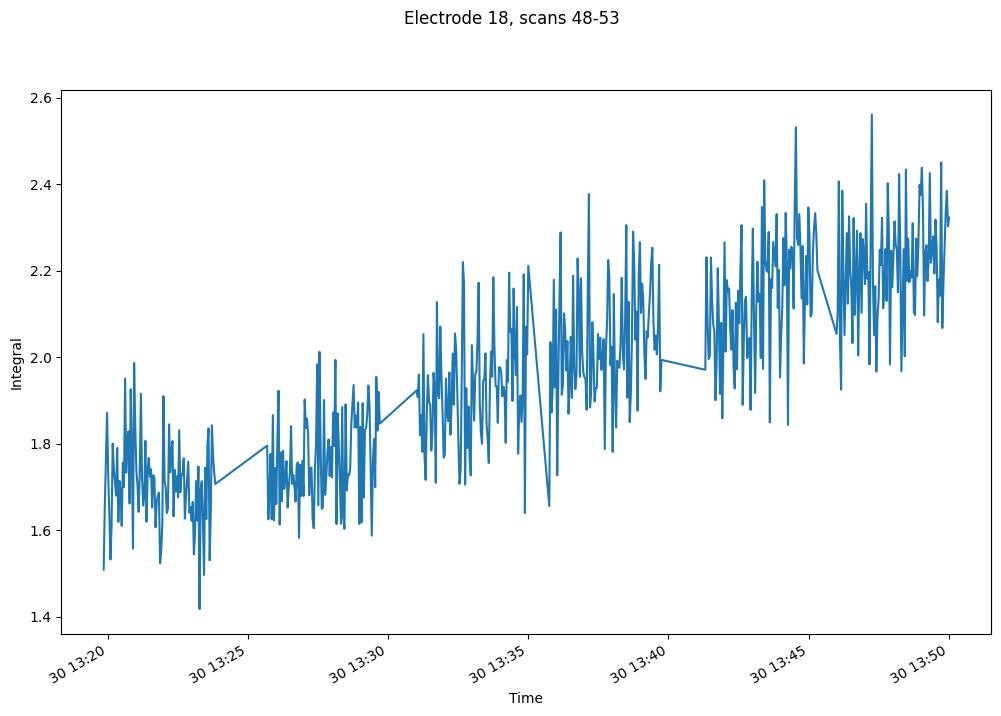

In [216]:

def foo():

    common = dict(pix2e_calibration=pixel_calibration,
                  roi=(310, 350),
                  roi_time1=(80, 135),
                  roi_time2=(170, 195),
                  vmax_image=130,
                  vmax_time=30
                  )

    data_18_48 = common | dict(filename="Electrode_18_0048.nxs")
    data_18_49 = common | dict(filename="Electrode_18_0049.nxs")
    data_18_50 = common | dict(filename="Electrode_18_0050.nxs")
    data_18_51 = common | dict(filename="Electrode_18_0051.nxs")
    data_18_52 = common | dict(filename="Electrode_18_0052.nxs")
    data_18_53 = common | dict(filename="Electrode_18_0053.nxs")


    plot = False
    df1 = extract_from_time_frames(**data_18_48, plot=plot)
    df2 = extract_from_time_frames(**data_18_49, plot=plot)
    df3 = extract_from_time_frames(**data_18_50, plot=plot)
    df4 = extract_from_time_frames(**data_18_51, plot=plot)
    df5 = extract_from_time_frames(**data_18_52, plot=plot)
    df6 = extract_from_time_frames(**data_18_53, plot=plot)
    df = pd.concat([df1, df2, df3, df4, df5, df6], axis=0)

    fig = plt.figure(figsize=(12, 8))
    fig.suptitle("Electrode 18, scans 48-53")
    df.plot()
    plt.xlabel("Time")
    plt.ylabel("Integral")
    # plt.ylim(0, )

foo()
